# Predicting Credit Card Defaults

With this demo we will be using a dataset of clients and their credit card history to determine if they will default. Let's first load in the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_excel('credit_card.xls', header=1)
df.rename(columns={'default payment next month':'default'}, inplace=True)

In [3]:
df = df.astype(float)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1.0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,2.0,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,3.0,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,4.0,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,5.0,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0


In [4]:
df.shape

(30000, 25)

In [5]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

## Feature Engineering
Now that our dataset is loaded in, lets do some feature engineering to clean up the data a bit more

First, lets drop the `ID` column since it will not be helping us when developing a model for the data

In [6]:
df.drop(['ID'], axis=1, inplace=True)

When looking at the `MARRIAGE` column, we can see that there is an extra value, 0, that is not described in UCI's description of the dataset. It is most logical to convert all `MARRIAGE` values of 0 to 3, which is indicative of "other"

In [7]:
df['MARRIAGE'].unique()

array([1., 2., 3., 0.])

In [8]:
df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3

The same problem is in the `EDUCATION` column. According to UCI's description, `EDUCATION` only has possible values of 1, 2, 3, and 4, where 4 is indicative of "other". We are going to convert all values of 0, 5, and 6 to 4

In [9]:
df['EDUCATION'].unique()

array([2., 1., 3., 5., 4., 6., 0.])

In [10]:
df.loc[df['EDUCATION'] == 0, 'EDUCATION'] = 4
df.loc[df['EDUCATION'] == 5, 'EDUCATION'] = 4
df.loc[df['EDUCATION'] == 6, 'EDUCATION'] = 4

## Simple Logistic Regression

Now, we are ready to start our classification task of determining credit card defaults. We are going to start off with a simple logistic regression model and then build up from there.

In [11]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, stratify=y)
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [12]:
clf = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=300, C=0.1)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
y_pred = clf.predict(X_test)
np.unique(y_pred)

array([0.])

In [14]:
print('Accuracy score:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy score: 0.7788
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      5841
         1.0       0.00      0.00      0.00      1659

   micro avg       0.78      0.78      0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.61      0.78      0.68      7500



/Users/matthewfan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matthewfan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matthewfan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As we can see, a simple logistic regression model will not properly classify our examples. The model ends up classifying each example as 0 (non-default), so although the accuracy is high, it gives a false sense that the model is good.

## Standardized Logistic Regression
Since our simple logistic regression model cannot properly classify our examples, lets introduce standardization and see if that helps our model.

In [15]:
logistic_regression = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=300, C=0.1)
pipeline = make_pipeline(StandardScaler(), logistic_regression)

In [16]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [17]:
y_pred = pipeline.predict(X_test)

In [18]:
print('Accuracy score:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))

Accuracy score: 0.8082666666666667
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      5841
         1.0       0.71      0.23      0.35      1659

   micro avg       0.81      0.81      0.81      7500
   macro avg       0.76      0.60      0.62      7500
weighted avg       0.79      0.81      0.77      7500

0.7050092764378478
0.22905364677516576


The standardized version is certainly much better than the original since it now predicts some accounts will default. However, the classification report tells us that this model is much better at predicting accounts that will not default, than accounts that will default. In context, the meaning of the recall score is out of how many accounts did we predict defaulting out of all the accounts that defaulted. And as we can see, the recall score is very low. 

## Improving Logistic Regression
In the following section, we will be looking at ways to manipulate our data set to improve the logistic regression model. 

In [19]:
df_mod = df.copy()

It seems that education is an important metric when determining default. As education level decreases, the proportion of defaults increases

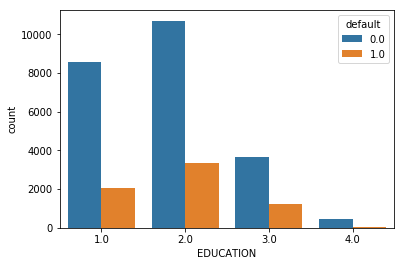

In [20]:
sns.countplot(x='EDUCATION', hue='default', data=df)

Sex also seems like an important metric: men are more likely to default than women.

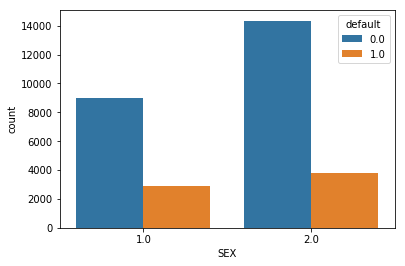

In [21]:
sns.countplot(x='SEX', hue='default', data=df)

It seems that married people are less likely to default.

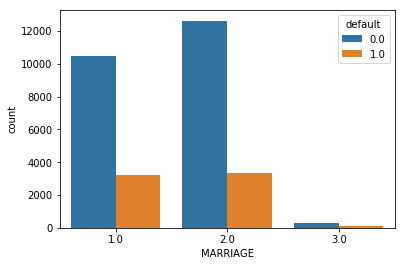

In [22]:
sns.countplot(x='MARRIAGE', hue='default', data=df)

Based on the graphs below, if an account does not pay on time, they are more likely to default

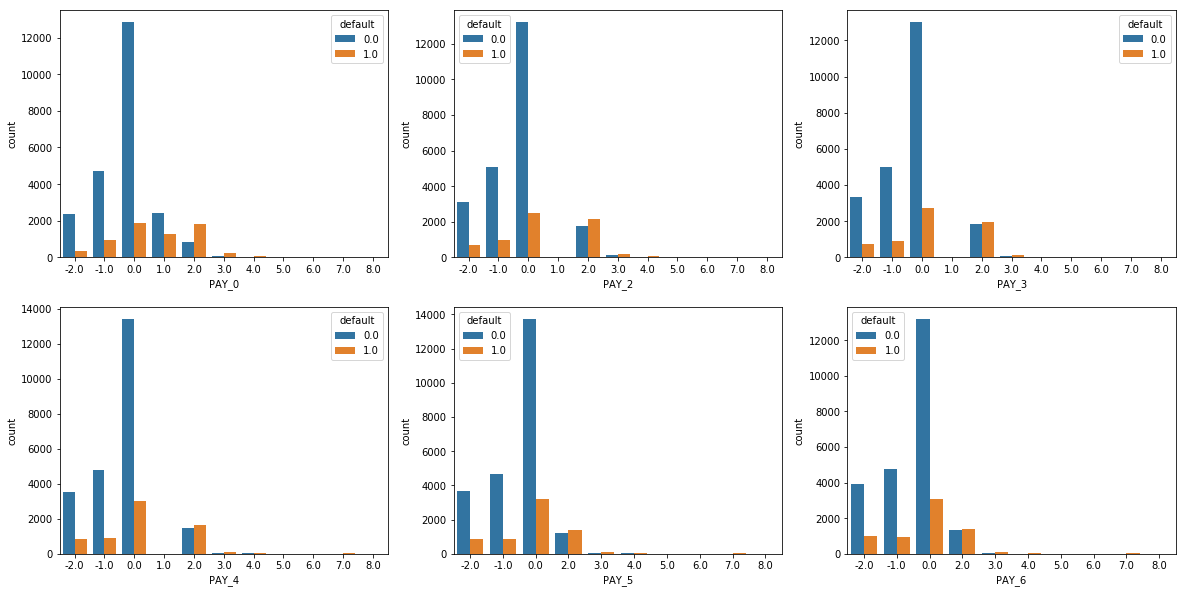

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
sns.countplot(x='PAY_0', hue='default', data=df, ax=ax[0,0])
sns.countplot(x='PAY_2', hue='default', data=df, ax=ax[0,1])
sns.countplot(x='PAY_3', hue='default', data=df, ax=ax[0,2])
sns.countplot(x='PAY_4', hue='default', data=df, ax=ax[1,0])
sns.countplot(x='PAY_5', hue='default', data=df, ax=ax[1,1])
sns.countplot(x='PAY_6', hue='default', data=df, ax=ax[1,2])

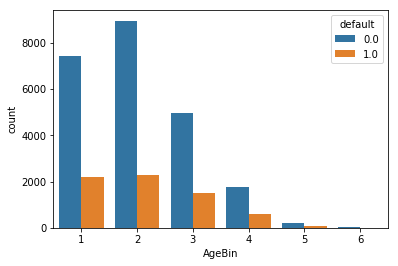

In [24]:
df_mod['AgeBin'] = 0 #creates a column of 0
df_mod.loc[((df['AGE'] > 20) & (df['AGE'] < 30)) , 'AgeBin'] = 1
df_mod.loc[((df['AGE'] >= 30) & (df['AGE'] < 40)) , 'AgeBin'] = 2
df_mod.loc[((df['AGE'] >= 40) & (df['AGE'] < 50)) , 'AgeBin'] = 3
df_mod.loc[((df['AGE'] >= 50) & (df['AGE'] < 60)) , 'AgeBin'] = 4
df_mod.loc[((df['AGE'] >= 60) & (df['AGE'] < 70)) , 'AgeBin'] = 5
df_mod.loc[((df['AGE'] >= 70) & (df['AGE'] < 81)) , 'AgeBin'] = 6


sns.countplot(x='AgeBin', hue='default', data=df_mod)

In [25]:
# 1 is male, 0 if female
df_mod['SEX'] = (df_mod['SEX'] == 1).astype(float) 

# 1 if paid late, 0 if paid on time
df_mod['PAY_0'] = (df_mod['PAY_0'] > 0).astype(float) 
df_mod['PAY_2'] = (df_mod['PAY_2'] > 0).astype(float) 
df_mod['PAY_3'] = (df_mod['PAY_3'] > 0).astype(float) 
df_mod['PAY_4'] = (df_mod['PAY_4'] > 0).astype(float) 
df_mod['PAY_5'] = (df_mod['PAY_5'] > 0).astype(float) 
df_mod['PAY_6'] = (df_mod['PAY_6'] > 0).astype(float) 

# One hot encoding of ages
df_mod['Age 20-29'] = (df_mod['AgeBin'] == 1).astype(float) 
df_mod['Age 30-39'] = (df_mod['AgeBin'] == 2).astype(float) 
df_mod['Age 40-49'] = (df_mod['AgeBin'] == 3).astype(float) 
df_mod['Age 50-59'] = (df_mod['AgeBin'] == 4).astype(float) 
df_mod['Age 60-69'] = (df_mod['AgeBin'] == 5).astype(float) 
df_mod['Age 70-81'] = (df_mod['AgeBin'] == 6).astype(float) 

df_mod.drop(['AGE'], axis=1, inplace=True)
df_mod.drop(['AgeBin'], axis=1, inplace=True)


df_mod

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,Age 20-29,Age 30-39,Age 40-49,Age 50-59,Age 60-69,Age 70-81
0,20000.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,120000.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1000.0,0.0,2000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,90000.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1000.0,1000.0,5000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,50000.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1100.0,1069.0,1000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,50000.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9000.0,689.0,679.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3047.0,5000.0,1000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29996,150000.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,129.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29997,30000.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,4200.0,2000.0,3100.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
29998,80000.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1926.0,52964.0,1804.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [26]:
X = df_mod.drop('default', axis=1)
y = df_mod[['default']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, stratify=y)
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [28]:
y_pred = pipeline.predict(X_test)

In [29]:
print('Accuracy score:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))

Accuracy score: 0.8070666666666667
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88      5841
         1.0       0.64      0.30      0.40      1659

   micro avg       0.81      0.81      0.81      7500
   macro avg       0.73      0.62      0.64      7500
weighted avg       0.78      0.81      0.78      7500

0.6380208333333334
0.29535864978902954


It seems like, with just some one-hot encoding we conducted on the dataset, our F1-score increased from 0.35 to 0.4

### Recursive Feature Elimination
One other technique we can try is to use Recursive Feature Elimination (RFE) to find which features are the most pertinent to the dataset. The RFE algorithm basically takes in the model that you want to test your data on, and recursively try each combination of features and see which ones are the most influential.

In [30]:
rfe = RFE(logistic_regression, n_features_to_select = 5)

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [32]:
rfe.fit(scaler.transform(X_train), y_train)
print("The rankings of which features are the most relevant: \n")
print(rfe.ranking_)

The rankings of which features are the most relevant: 

[ 1  8 16  6  1 12  1  9  1  4  5  3  7 17 19 13  2  1 18 10 24 11 15 14
 21 23 20 22]


In [33]:
rfe.support_

array([ True, False, False, False,  True, False,  True, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False])

In [34]:
X_train_trim = X_train.loc[:, rfe.support_]
X_test_trim = X_test.loc[:, rfe.support_]

In [35]:
X_test_trim

,LIMIT_BAL,PAY_0,PAY_3,PAY_5,PAY_AMT2
6345,450000.0,1.0,0.0,0.0,0.0
11956,130000.0,0.0,0.0,0.0,5067.0
22327,100000.0,1.0,0.0,0.0,0.0
21668,80000.0,0.0,0.0,0.0,3000.0
5064,20000.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...
16096,80000.0,1.0,0.0,0.0,0.0
21300,20000.0,0.0,0.0,0.0,2580.0
8288,80000.0,0.0,0.0,0.0,2000.0
377,140000.0,0.0,0.0,0.0,3855.0


Now that we condensed our dataset to just 5 features, let's see how it performs on the test set now.

In [36]:
pipeline.fit(X_train_trim, y_train)
y_pred = pipeline.predict(X_test_trim)

print('Accuracy score:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))

Accuracy score: 0.8064
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88      5841
         1.0       0.64      0.29      0.40      1659

   micro avg       0.81      0.81      0.81      7500
   macro avg       0.73      0.62      0.64      7500
weighted avg       0.78      0.81      0.78      7500

0.6367239101717305
0.29053646775165765


As we can see, the results are essentially the same, meaning that the result is mostly dictated by these most influential features. 

## Random Forest Classifier
Now that we developed some logistic regression models, we will move on to trying other classification models. In particular, here we will be using the Random Forest Classifier.

In [43]:
rfc = RandomForestClassifier(random_state=100)
pipeline = make_pipeline(StandardScaler(), rfc)

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # # Create the random grid
# # hyperparameters = {
# # #     'randomforestclassifier__bootstrap': [True],
# # #     'randomforestclassifier__max_depth': [80, 90, 100, 110],
# # #     'randomforestclassifier__max_features': [2, 3],
# # #     'randomforestclassifier__min_samples_leaf': [3, 4, 5],
# # #     'randomforestclassifier__min_samples_split': [8, 10, 12],
# #     'randomforestclassifier__n_estimators': [100, 200, 300]
# # }

hyperparameters = {
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': [None, 5, 3], 
    'randomforestclassifier__n_estimators': [50, 100, 200]
}

display(hyperparameters)

clf = GridSearchCV(pipeline, param_grid=hyperparameters, cv=5)

{'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
 'randomforestclassifier__max_depth': [None, 5, 3],
 'randomforestclassifier__n_estimators': [50, 100, 200]}

In [44]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...s='warn', n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'], 'randomforestclassifier__max_depth': [None, 5, 3], 'randomforestclassifier__n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
y_pred = clf.predict(X_test)

print('Accuracy score:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))

Accuracy score: 0.8092
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88      5841
         1.0       0.63      0.34      0.44      1659

   micro avg       0.81      0.81      0.81      7500
   macro avg       0.73      0.64      0.66      7500
weighted avg       0.79      0.81      0.79      7500

0.6258278145695364
0.34177215189873417


It seems like using an ensemble algorithm like Random Forest Classifier increases our F1-score up to 0.44, from our F1-score of 0.4 with the logistic regression.